# INTRODUCTION 🦠

![](https://www.hopkinsmedicine.org/-/media/images/health/1_-conditions/liver-gallbladder-and-pancreas/hepatitis-teaser-image.jpg)

Hepatitis, essentially, is a disease that causes liver inflammation, as shown above. Since the liver is vital in fighting off infections, Hepatitis is very harmful, causing symptoms such as dark urine, fever, pain, and quite frequently, death. There are many types of Hepatitis, but I will be using a dataset of Hepatitis patients that examines the virus generally, without delving into each specific type. Hepatitis is usually caused by transmission through sex or food and liquids, and causes around 1.34 million deaths per year worldwide.



In [1]:
#Loading in the dataset.
library(readr)
data <- read_csv("/kaggle/input/hepatitis-data/hepatitis_csv.csv")

Rows: 155 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): sex, class
dbl  (6): age, bilirubin, alk_phosphate, sgot, albumin, protime
lgl (12): steroid, antivirals, fatigue, malaise, anorexia, liver_big, liver_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# EDA 📊 (ggplot2)

In this notebook I will be examining the relationship between the binary 'class' variable in the dataset, which is whether or not each patient lived or died, and every other 19 variables, which include details about every patient.

I will be grouping these 19 explanatory variables into 4 groups:
* Demographics for each patient 👴
* Symptoms of each patient 🤒
* The treatments each patient received 💉
* Biomarkers of each patient's liver health 🧪

**Starting with the patient demographics, there are two visible trends between age and sex and whether patients lived or died:
1. Only women died. This is enough to show us that a prediction model for survival based on sex is useless, as there is no data to be trained on for survival based on sex.
2. Older people usually died. 

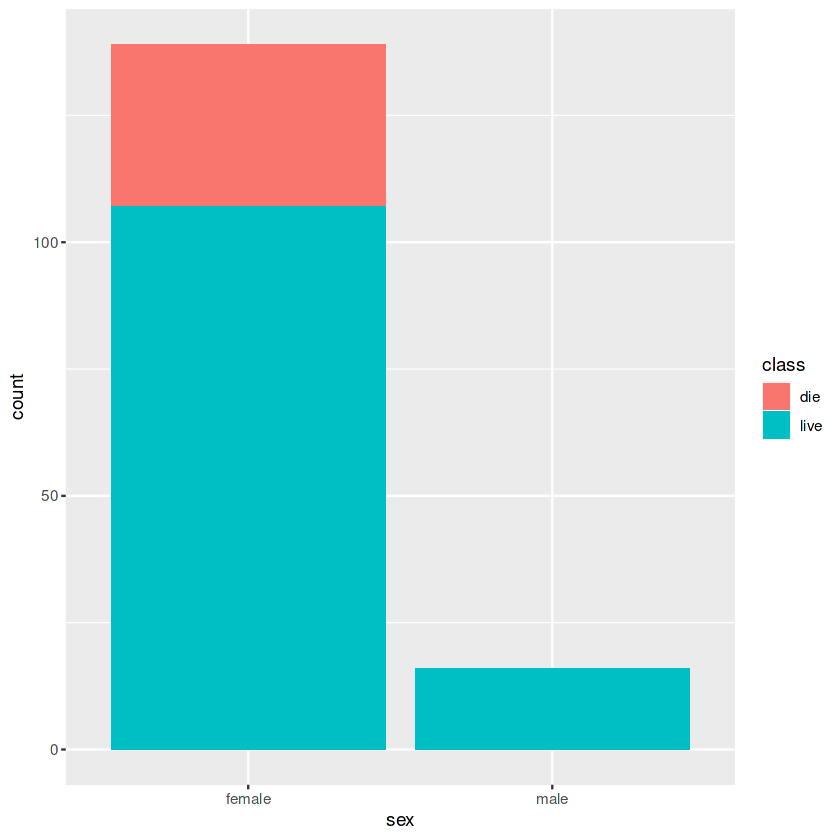

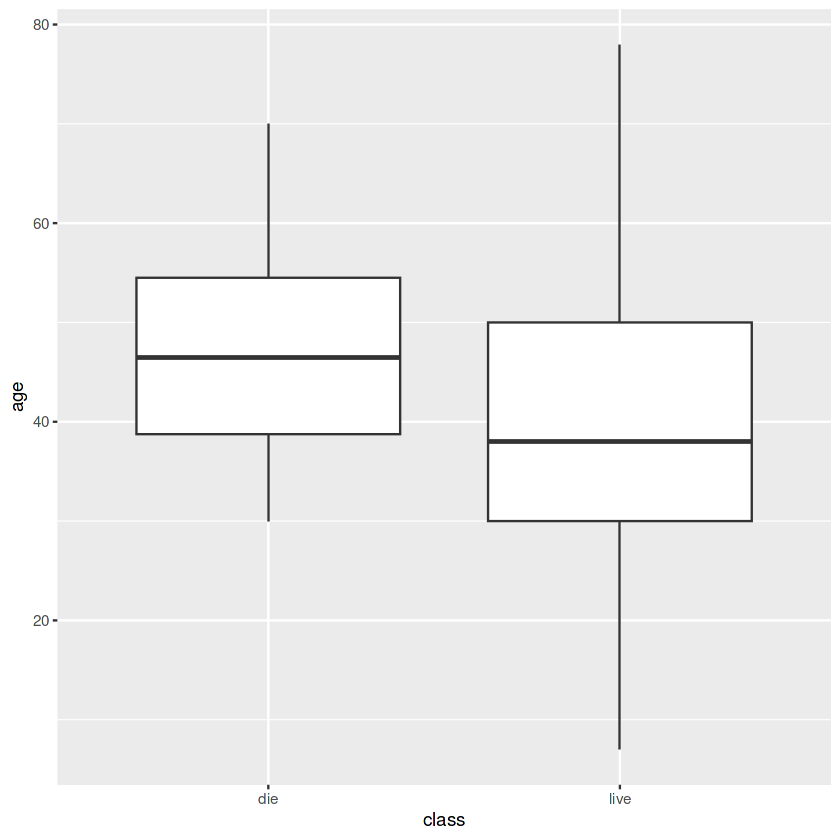

In [2]:
library(ggplot2)

#1.
ggplot(data, aes(x = `sex`, fill = `class`)) + geom_bar()

#2.
ggplot(data, aes(x = `class`, y = `age`)) + geom_boxplot()

**For next three groups of explanatory variables, however, it would be too tedious to graph every variable as a function of class, and so I will only show a few that display the general trends:**
1. More people who did NOT receive steroids for treatment died.
2. More people with malaise (discomfort) symptoms died.
3. People with bigger livers died more. Bigger livers are a common symptom of Hepatitis.
4. Higher levels of bilirubin, which indicates a less healthy liver as bilirubin is a biomarker for liver health, correlated with more deaths.

**BUT OVERALL, TO SAVE YOU SOME TIME FROM READING COMPARISONS OF EVERY SINGLE COLUMN: HIGHER PROPORTIONS OF PEOPLE WITH WORSE SYMPTOMS AND LESS TREATMENTS DIED.**

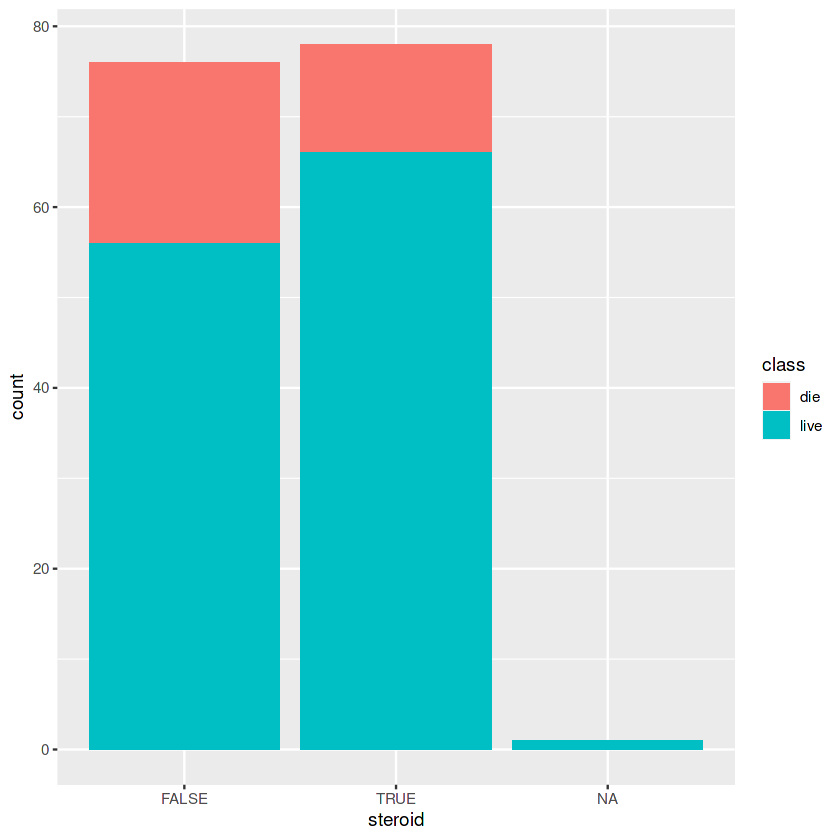

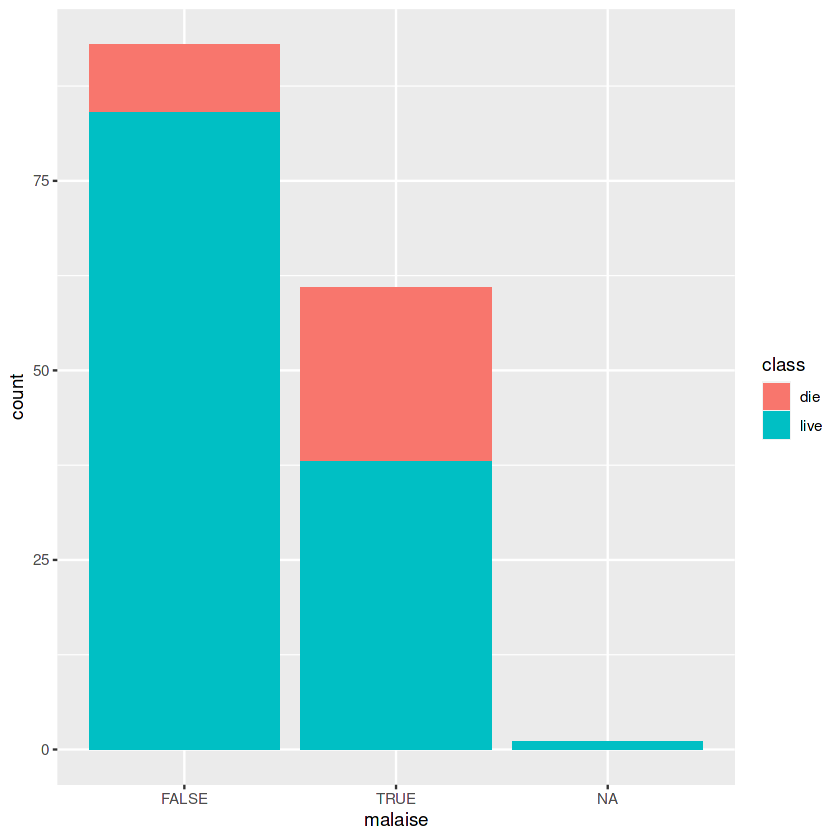

Warning message:
“Removed 6 rows containing non-finite values (`stat_count()`).”


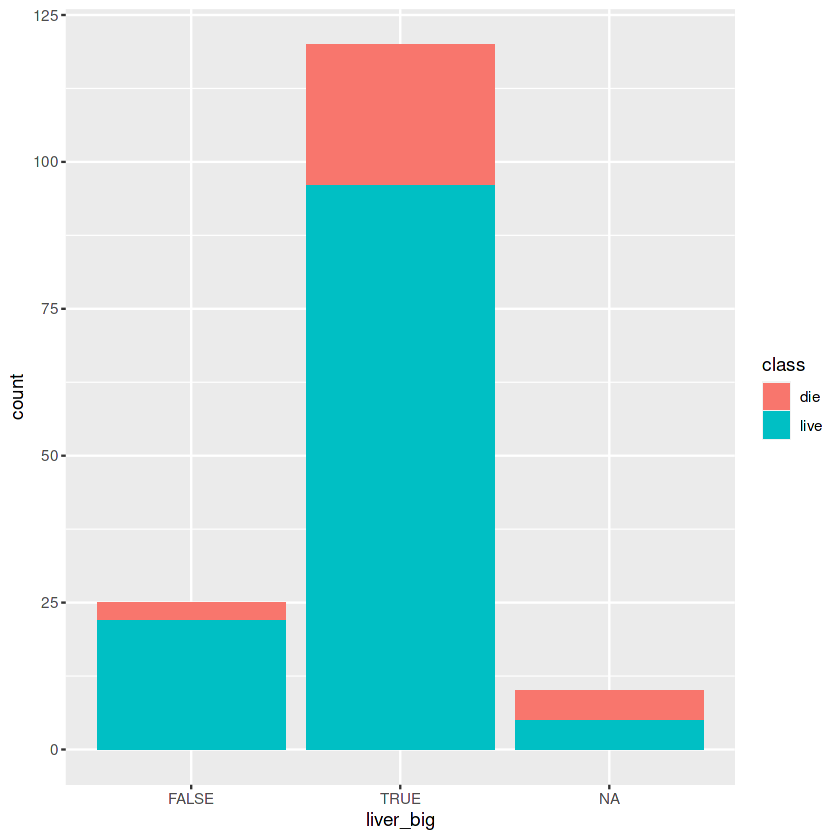

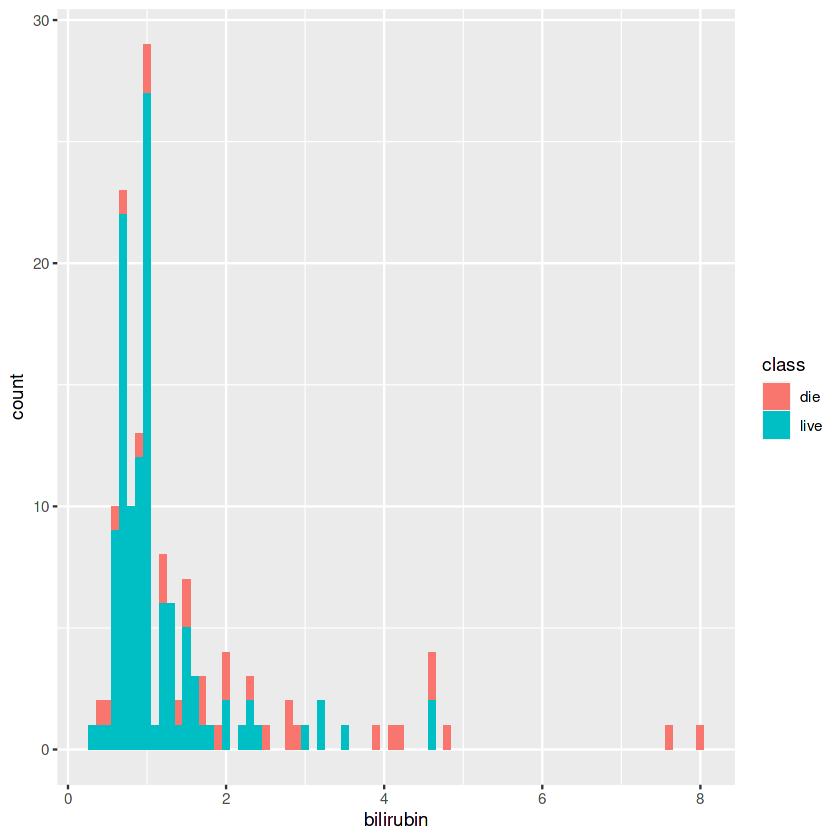

In [3]:
#1.
ggplot(data, aes(x = `steroid`, fill = `class`)) + geom_bar()

#2.
ggplot(data, aes(x = `malaise`, fill = `class`)) + geom_bar()

#3.
ggplot(data, aes(x = `liver_big`, fill = `class`)) + geom_bar()

#4.
ggplot(data, aes(x = `bilirubin`, fill = `class`)) + geom_bar()

In [4]:
#Importing the libraries.
library(tidyverse)
library(glmnet)
library(randomForest)
library(vip)

#Omitting all the NA values and putting them in a new dataset that can be used for building a model. 
naless_data <- na.omit(data)

#I will be converting the class variable into a numeric binary variable so it is suitable for using in models I will be using.
naless_data <- naless_data %>%
  mutate(class = ifelse(class == "live", 1, 0))

#Splitting the data using a 70/30 training/testing split 
library(rsample)
set.seed(69420)
split <- initial_split(naless_data, prop = 0.7)
TRD <- training(split)
#Training Data
TED <- testing(split)
#Testing Data

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ stringr   1.5.0
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-7

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi




**Starting off with models comparing the demographics of patients, the treatments they received, and the symptoms of each patient, all with the class of each patient, the R^2 values for each model shows that the relationships between these three groups the class is not significant.**

👴 Starting off with the demographics, the R^2 value isn't great, to say the least.

In [5]:
rf_model <- randomForest(class ~ age + sex, data = TRD, proximity = TRUE)

predictions <- predict(rf_model, TED)

R2 <- 1 - var(TED$class - predictions) / var(TED$class)
R2

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.1287358

🤒 The R^2 value for the model comparing the symptoms of each patient to the class is also.

In [6]:
rf_model2 <- randomForest(class ~ fatigue + malaise + liver_big + liver_firm + spleen_palpable + spiders + varices + anorexia + ascites, data = TRD, proximity = TRUE)

predictions2 <- predict(rf_model2, TED)

R2 <- 1 - var(TED$class - predictions) / var(TED$class)
R2

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.1287358

💉 Last and certainly least, the R^2 value for the treatments the patients received managed to be even worse.

In [7]:
rf_model3 <- randomForest(class ~ steroid + antivirals, data = TRD, proximity = TRUE)

predictions3 <- predict(rf_model3, TED)

R2 <- 1 - var(TED$class - predictions) / var(TED$class)
R2

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.1287358

**🧪 BUT, the biomarkers of liver health have come in to save the day! Comparing liver health to whether a patient is alive or dead provides an R^2 value high enough to say that there is a statistically significant relationship between the variables.**

In [8]:
rf_model4 <- randomForest(class ~ bilirubin + alk_phosphate + sgot + albumin + protime, data = naless_data, proximity = TRUE)

predictions4 <- predict(rf_model4, TED, type = "response")

R2 <- 1 - var(TED$class - predictions) / var(TED$class)
R2

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


[1] 0.1287358

**Outputting the predictions for the liver health randomForest model, however, we get a set of decimal values. But, this can be easily fixed by setting a treshold for either a 0 (dead) or 1(alive) class value as shown below:**

In [9]:
#First, we will set thresholds for either the lowest percentage one can have for being alive to be classified as alive, and the highest percentage one can have for being classified as dead.
#Feel free to change these tresholds.
lowestalive <- 0.6
highestdead <- 0.4

# We will then create binary class labels based on the thresholds
predicted_labels <- ifelse(predictions4 > lowestalive, 1, ifelse(predictions4 < highestdead, 0, 0.5))

#In this case, 0.5 would mean a diagnosis we are unsure of. This range of unsure diagnoses is up to you - these are just the values I picked.

#Outputting the labels:
predicted_labels

1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.5 0.0 1.0 0.0 
 21  22  23  24 
1.0 0.0 1.0 0.0

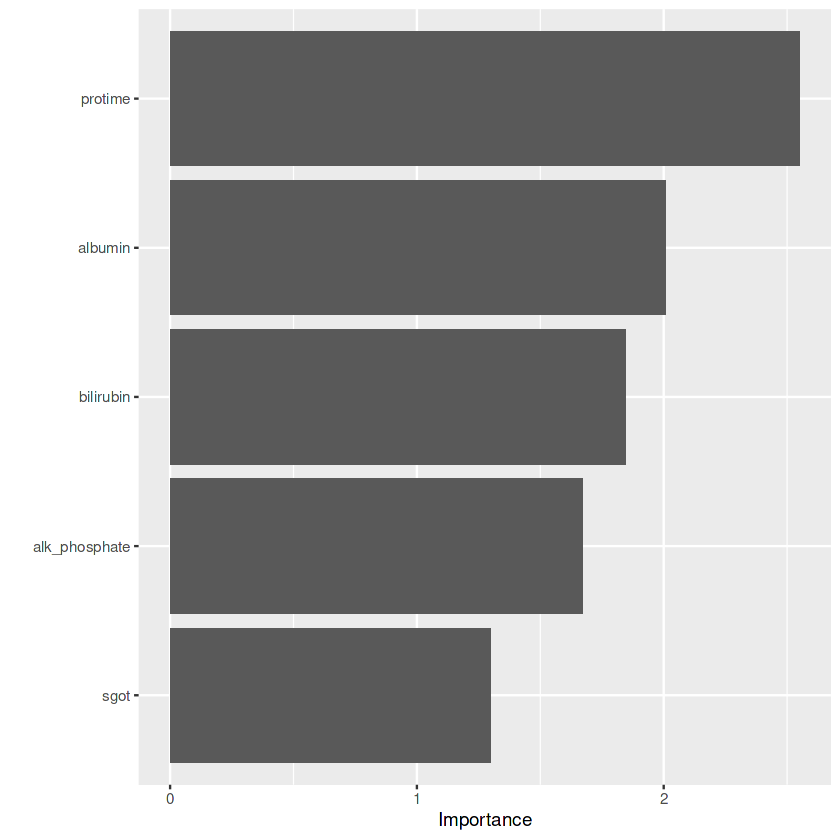

In [10]:
#As a final note, the vip() function also allows us to see the rankings of importance of the biomarkers of liver health in determining the class of each patient.
vip(rf_model4)

**Ultimately, this randomForest model comparing variables bilirubin, alk_phosphate, sgot, albumin, and protime, was the most accurate in predicting a Hepatitis patient's survival.
I did mess around with having explanatory variables of multiple of the aforementioned 4 groups (demographics, symptoms, treatments, and biomarkers of liver health), but not only were they mixed between different, incompatible data types, they also had much lower accuracy rates and R^2 values, and were not significant enough to put on this notebook.
**